In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ezaaputra/indonlu.git

Cloning into 'indonlu'...
remote: Enumerating objects: 460, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 460 (delta 119), reused 108 (delta 108), pack-reused 312 (from 1)
Receiving objects: 100% (460/460), 4.83 MiB | 2.94 MiB/s, done.
Resolving deltas: 100% (229/229), done.


# 1. Import Library

In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import defaultdict

# NLP
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import emoji

# Viz
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from wordcloud import WordCloud

#Model IndoBERT
import random
import torch
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm

from transformers import BertForSequenceClassification, BertConfig, BertTokenizer
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


# 2. Exploratory Data Analysis

In [ ]:
df_path = 'drive/MyDrive/Data/dataset_revisi.tsv'
stopword_path = 'drive/MyDrive/Data/stopword.txt'
kamus_alay_path = 'drive/MyDrive/Data/kamus_alay.csv'

In [ ]:
# Import data
df = pd.read_csv(df_path, sep='\t', names=['text', 'category'])
# df = pd.read_csv(df_path, sep=',', names=['text', 'category'])

In [ ]:
df.sample(10)

,text,category
14256,Penegakan hukum tebang pilih banget.,negative
13910,"Pelayanan publik lambat banget, kayak nggak ni...",negative
3869,Bener sis Visi Kerja Prabowo-Gibran mampu memb...,positive
4331,Setuju gue sis raihan Visi Kerja Prabowo-Gibra...,positive
8908,MOHON IZIN BAPAK UNTUK PUPUK IZIN DI PERMURAH ...,neutral
12403,Tapi mungut nya ke rakyat kecil PPN 12% itu di...,negative
9147,Yang terpenting smoga pak Prabowo slalu d lind...,neutral
3902,Setuju sis Visi Kerja Prabowo-Gibran dapat men...,positive
11043,Kami sekeluarga msih kelaperan Pak,negative
7669,pemerintah dijadwalkan akan membahas reformasi...,neutral


In [ ]:
print(f'shape: {df.shape}')

shape: (16017, 2)


## Proporsi Variabel Target

In [ ]:
df['category'].value_counts()

,count
category,
negative,6240
positive,6064
neutral,3713


In [ ]:
# Function to make a donut chart
def donut(sizes, ax, angle=90, labels=None, colors=None, explode=None, shadow=None):

  # plot
  ax.pie(sizes, colors = colors, labels=labels, autopct='%.1f%%',
         startangle = angle, pctdistance=0.8, explode = explode,
         wedgeprops=dict(width=0.4), shadow=shadow)

  # Formatting
  plt.axis('equal')
  plt.tight_layout()

In [ ]:
# Plot arguments
sizes = df.category.value_counts()
labels = ['Negatif', 'Positif', 'Netral']
colors = ['lightgreen', 'lightskyblue', 'lightcoral']
explode = (0,0,0)

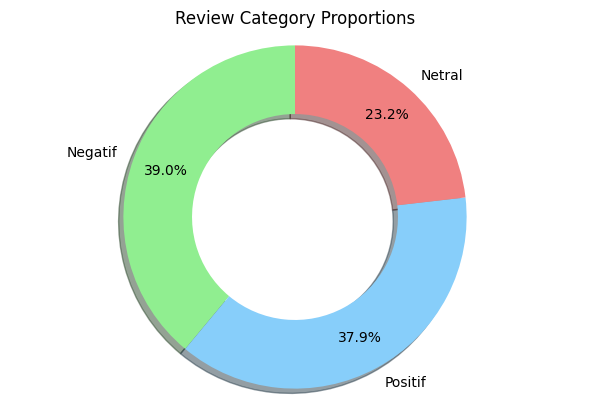

In [ ]:
# Create axes
f, ax = plt.subplots(figsize=(6,4))

# plot donut
donut(sizes, ax, 90, labels, colors=colors, explode=explode, shadow=True)
ax.set_title('Review Category Proportions')

plt.show()

# 3. PreProcessing

## Preprocessing Tahap 1

In [ ]:
character = ['.',',',';',':','-,','...','?','!','(',')','[',']','{','}','<','>','"','/','\'','#','-','@',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']

# hapus karakter yang berulang
def repeatcharClean(text):
  for i in range(len(character)):
    charac_long = 5
    while charac_long > 2:
      char = character[i]*charac_long
      text = text.replace(char, character[i])
      charac_long -= 1
  return text

In [ ]:
def clean_review(text):
  # ubah text menjadi huruf kecil
  text = text.lower()
  # ubah enter menjadi spasi
  text = re.sub(r'\n', ' ', text)
  # hapus emoji
  text = emoji.demojize(text)
  text = re.sub(':[A-Za-z_-]+:', ' ', text) # delete emoji
  # hapus emoticon
  text = re.sub(r"([xX;:]'?[dDpPvVoO3)(])", ' ', text)
  # hapus link
  text = re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", text)
  # hapus usename
  text = re.sub(r"@[^\s]+[\s]?", ' ', text)
  # hapus hashtag
  text = re.sub(r'#(\S+)', r'\1', text)
  # hapus angka dan beberapa simbol
  text = re.sub('[^a-zA-Z,.?!]+',' ',text)
  # hapus karakter berulang
  text = repeatcharClean(text)
  # clear spasi
  text = re.sub('[ ]+',' ',text)
  return text

In [ ]:
def preprocess_v1(df):
  df_pp = df.copy()
  df_pp.text = df_pp.text.apply(clean_review)

  # delete empty row
  # df_pp.text.replace('', np.nan, inplace=True)
  # df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp['text'] = df_pp['text'].replace(['', ' '], np.nan)

  # df_pp.dropna(subset=['text'], inplace=True)
  df_pp = df_pp.dropna(subset=['text'])
  return df_pp

In [ ]:
df_v1 = preprocess_v1(df)

In [ ]:
# export to csv
df_v1.to_csv('df_v1.tsv', sep='\t', header=None, index=False)
# df_v1.to_csv('df_v1.csv', sep=',', header=None, encoding='utf8', index=False)

## Preprocessing Tahap 2

In [ ]:
# additional_stopword:list kata tdk penting
additional_stop = [] #['ya', 'deh', 'dia']

# default stopword
default_stop = pd.read_csv(stopword_path, sep=',', names=['stopwords'])
default_stop = default_stop.stopwords.to_list()

# combine all stopword
list_stopwords = []
list_stopwords = default_stop + additional_stop

# remove specific stopword
# list_stopwords.remove("sangat")
# list_stopwords.remove("sekali")

In [ ]:
kamus_alay = pd.read_csv(kamus_alay_path)

# normalize_word_dict = {}
# for index, row in kamus_alay.iterrows():
#     if row[0] not in normalize_word_dict:
#         normalize_word_dict[row[0]] = row[1]

normalize_word_dict = {}
for index, row in kamus_alay.iterrows():
    if row.iloc[0] not in normalize_word_dict:  # Gunakan .iloc untuk mengakses posisi
        normalize_word_dict[row.iloc[0]] = row.iloc[1]

In [ ]:
def normalize_review(text):
  # tokenize
  list_text = word_tokenize(text)

  # ubah bahasa alay
  list_text = [normalize_word_dict[term] if term in normalize_word_dict else term for term in list_text]

  # stemming
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  list_text = [stemmer.stem(word) for word in list_text]

  # hapus kata yang termasuk stopword
  list_text = [word for word in list_text if word not in list_stopwords]

  # gabung kembali kalimat
  text = " ".join(list_text)
  return text

In [ ]:
def preprocess_v2(df):
  df_pp = df.copy()
  df_pp.text = df_pp.text.map(normalize_review)

  # delete empty row
  # df_pp.text.replace('', np.nan, inplace=True)
  # df_pp.text.replace(' ', np.nan, inplace=True)
  df_pp['text'] = df_pp['text'].replace(['', ' '], np.nan)

  # df_pp.dropna(subset=['text'], inplace=True)
  df_pp = df_pp.dropna(subset=['text'])
  return df_pp

In [ ]:
# take a while
df_v2  = preprocess_v2(df_v1)

In [ ]:
# export to csv
df_v2.to_csv('df_v2.tsv', sep='\t', header=None, index=False)
# df_v2.to_csv('df_v2.csv', sep=',', header=None, encoding='utf8', index=False)

In [ ]:
def make_corpus(column):

    corpus_list = []

    for text in column:
        cleaned_list = text.split(' ')
        corpus_list.extend(cleaned_list)

    # transform list of words into 1 body of text
    corpus = ' '.join(corpus_list)
    corpus = re.sub('[ ]+',' ',corpus) # replace double whitespace with one

    return corpus

In [ ]:
# Takes a while
corpus = make_corpus(df_v2.text)

In [ ]:
# counting unique words
corpus_set = set(corpus.split(' '))

print(f'Count of unique words in corpus: {len(corpus_set)}')

Count of unique words in corpus: 12578


In [ ]:
# function for freqdist
def word_freq(corpus, top=5):
    tokenized_word = word_tokenize(corpus)
    freqdist = FreqDist(tokenized_word)
    freqdist = freqdist.most_common(top) # list of tuples

    # decompose into label and frequency
    label = [tup[0] for tup in freqdist]
    freq = [tup[1] for tup in freqdist]
    df = pd.DataFrame({'word':label, 'freq':freq})

    return df

In [ ]:
corpus_freq = word_freq(corpus, top=20)

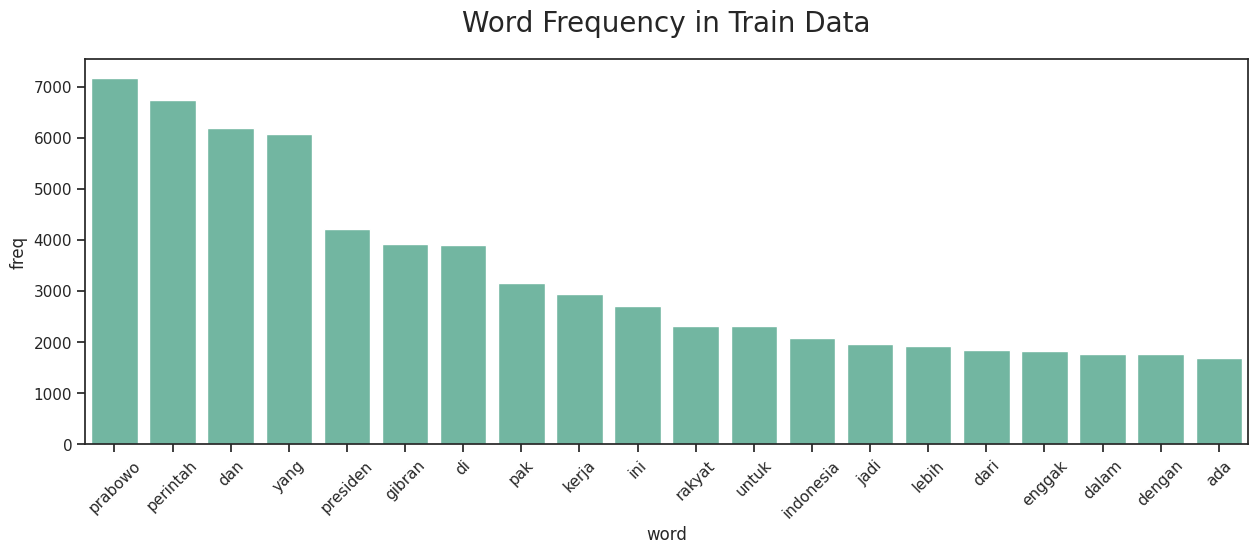

In [ ]:
# Config params
plt.style.use('default')
sns.set(style='ticks', palette='Set2')
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.titlepad'] = 20

# Compare plots of train and test corpus
f, ax1 = plt.subplots(1,figsize=(15,5))

sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax1)
ax1.set_title('Word Frequency in Train Data')
ax1.tick_params(axis='x', rotation=45)

# sns.barplot(x='word', y='freq', data=corpus_freq, ax=ax2)
# ax2.set_title('Word Frequency in Train Data')
# ax2.tick_params(axis='x', rotation=45)

# sns.despine(ax=ax1)
# sns.despine(ax=ax2)
plt.show()

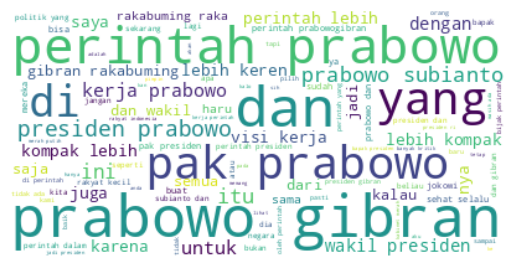

In [ ]:
# Cloud for corpus
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# 4. Splitting

In [ ]:
# train val split
# train_set, val_set = train_test_split(df_v2, test_size=0.3, stratify=df_v2.category, random_state=1)
# val_set, test_set = train_test_split(val_set, test_size=0.3, stratify=val_set.category, random_state=1)

train_set, val_set = train_test_split(df_v2, test_size=0.1, stratify=df_v2.category, random_state=1)
val_set, test_set = train_test_split(val_set, test_size=0.1, stratify=val_set.category, random_state=1)

In [ ]:
print(f'Train shape: {train_set.shape}')
print(f'Val shape: {val_set.shape}')
print(f'Test shape: {test_set.shape}')

Train shape: (14415, 2)
Val shape: (1441, 2)
Test shape: (161, 2)


In [ ]:
# export to csv
train_set.to_csv('train_set.tsv', sep='\t', header=None, index=False)
val_set.to_csv('val_set.tsv', sep='\t', header=None, index=False)
test_set.to_csv('test_set.tsv', sep='\t', header=None, index=False)

# train_set.to_csv('train_set.csv', sep=',', header=None, encoding='utf8', index=False)
# val_set.to_csv('val_set.csv', sep=',', header=None, encoding='utf8', index=False)
# test_set.to_csv('test_set.csv', sep=',', header=None, encoding='utf8', index=False)

# 5. Modeling

## a. Finetuning IndoBERT

In [ ]:
###
# common functions
###
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def metrics_to_string(metric_dict):
    string_list = []
    for key, value in metric_dict.items():
        string_list.append('{}:{:.2f}'.format(key, value))
    return ' '.join(string_list)

In [ ]:
# Set random seed
set_seed(27)

## b. Load Model

In [ ]:
# Load Tokenizer and Config
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p1')
config.num_labels = DocumentSentimentDataset.NUM_LABELS

# Instantiate model
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p1', config=config)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Struktur model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
count_param(model)

124443651

## c. Prepare Dataset

In [ ]:
train_dataset_path = '/content/train_set.tsv'
valid_dataset_path = '/content/val_set.tsv'
test_dataset_path = '/content/test_set.tsv'

# train_dataset_path = '/content/train_set.csv'
# valid_dataset_path = '/content/val_set.csv'
# test_dataset_path = '/content/test_set.csv'

In [ ]:
# fungsi dataset loader dari utils IndoNLU
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

# train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=True)
# valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)
# test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=16, shuffle=False)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=4, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=4, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=4, shuffle=False)

# train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=256, batch_size=64, num_workers=4, shuffle=True)
# valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=256, batch_size=64, num_workers=4, shuffle=False)
# test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=256, batch_size=64, num_workers=4, shuffle=False)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i) #word to index
print(i2w) #index to word

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


## d. Uji coba pre-trained model

In [ ]:
# text = 'Pemerintahan Prabowo dan Gibran dianggap belum memenuhi ekspektasi sebagian masyarakat karena masih banyak janji kampanye yang belum terealisasi secara nyata.'
text = 'Pemerintahan Prabowo dan Gibran dianggap gagal total dalam menepati janji kampanye. Banyak program tidak jelas arahnya dan rakyat merasa kecewa dengan hasil kerja yang jauh dari harapan.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Text: Pemerintahan Prabowo dan Gibran dianggap gagal total dalam menepati janji kampanye. Banyak program tidak jelas arahnya dan rakyat merasa kecewa dengan hasil kerja yang jauh dari harapan. | Label : neutral (53.499%)


In [ ]:
text = 'Di bawah kepemimpinan Prabowo dan Gibran, pemerintah menetapkan sejumlah program strategis untuk pembangunan nasional. apakah sesuai dengan visi dan misinya?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Di bawah kepemimpinan Prabowo dan Gibran, pemerintah menetapkan sejumlah program strategis untuk pembangunan nasional. apakah sesuai dengan visi dan misinya? | Label : neutral (44.249%)


In [ ]:
text = 'Pemerintahan Prabowo dan Gibran membawa angin segar bagi Indonesia dengan kebijakan inovatif yang fokus pada kemajuan ekonomi, pendidikan, dan kesejahteraan rakyat.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Pemerintahan Prabowo dan Gibran membawa angin segar bagi Indonesia dengan kebijakan inovatif yang fokus pada kemajuan ekonomi, pendidikan, dan kesejahteraan rakyat. | Label : neutral (51.713%)


## e. Fine Tuning & Prediksi Evaluation

In [ ]:
# Tentukan optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()
# model = model.cpu()

### Training

In [ ]:
# Train
n_epochs = 5
history = defaultdict(list)
for epoch in range(n_epochs):
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp_train, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        tr_loss = loss.item()
        total_train_loss = total_train_loss + tr_loss

        # Hitung skor train metrics
        list_hyp_train += batch_hyp
        list_label += batch_label

        train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} LR:{:.8f}".format((epoch+1),
            total_train_loss/(i+1), get_lr(optimizer)))

    metrics = document_sentiment_metrics_fn(list_hyp_train, list_label)
    print("(Epoch {}) TRAIN LOSS:{:.4f} {} LR:{:.8f}".format((epoch+1),
        total_train_loss/(i+1), metrics_to_string(metrics), get_lr(optimizer)))

    # save train acc for learning curve
    history['train_acc'].append(metrics['ACC'])

    # Evaluate di validation set
    model.eval()
    torch.set_grad_enabled(False)

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(pbar):
        batch_seq = batch_data[-1]
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Hitung total loss
        valid_loss = loss.item()
        total_loss = total_loss + valid_loss

        # Hitung skor evaluation metrics
        list_hyp += batch_hyp
        list_label += batch_label
        metrics = document_sentiment_metrics_fn(list_hyp, list_label)

        pbar.set_description("VALID LOSS:{:.4f} {}".format(total_loss/(i+1), metrics_to_string(metrics)))

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print("(Epoch {}) VALID LOSS:{:.4f} {}".format((epoch+1),
        total_loss/(i+1), metrics_to_string(metrics)))

    # save validation acc for learning curve
    history['val_acc'].append(metrics['ACC'])


(Epoch 1) TRAIN LOSS:0.5386 LR:0.00000300: 100%|██████████| 451/451 [02:46<00:00,  2.72it/s]


(Epoch 1) TRAIN LOSS:0.5386 ACC:0.79 F1:0.77 REC:0.76 PRE:0.78 LR:0.00000300


  0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.4120 ACC:0.83 F1:0.82 REC:0.81 PRE:0.83: 100%|██████████| 46/46 [00:05<00:00,  7.68it/s]


(Epoch 1) VALID LOSS:0.4120 ACC:0.83 F1:0.82 REC:0.81 PRE:0.83


  0%|          | 0/451 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 2) TRAIN LOSS:0.3552 LR:0.00000300: 100%|██████████| 451/451 [02:51<00:00,  2.63it/s]


(Epoch 2) TRAIN LOSS:0.3552 ACC:0.86 F1:0.85 REC:0.84 PRE:0.86 LR:0.00000300


  0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.3908 ACC:0.85 F1:0.83 REC:0.83 PRE:0.84: 100%|██████████| 46/46 [00:05<00:00,  7.93it/s]


(Epoch 2) VALID LOSS:0.3908 ACC:0.85 F1:0.83 REC:0.83 PRE:0.84


  0%|          | 0/451 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 3) TRAIN LOSS:0.2940 LR:0.00000300: 100%|██████████| 451/451 [02:50<00:00,  2.64it/s]


(Epoch 3) TRAIN LOSS:0.2940 ACC:0.89 F1:0.88 REC:0.87 PRE:0.88 LR:0.00000300


  0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.3836 ACC:0.85 F1:0.84 REC:0.84 PRE:0.85: 100%|██████████| 46/46 [00:06<00:00,  7.61it/s]


(Epoch 3) VALID LOSS:0.3836 ACC:0.85 F1:0.84 REC:0.84 PRE:0.85


  0%|          | 0/451 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 4) TRAIN LOSS:0.2409 LR:0.00000300: 100%|██████████| 451/451 [02:50<00:00,  2.65it/s]


(Epoch 4) TRAIN LOSS:0.2409 ACC:0.91 F1:0.90 REC:0.90 PRE:0.91 LR:0.00000300


  0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.4043 ACC:0.86 F1:0.85 REC:0.84 PRE:0.85: 100%|██████████| 46/46 [00:05<00:00,  7.94it/s]


(Epoch 4) VALID LOSS:0.4043 ACC:0.86 F1:0.85 REC:0.84 PRE:0.85


  0%|          | 0/451 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
(Epoch 5) TRAIN LOSS:0.1951 LR:0.00000300: 100%|██████████| 451/451 [02:51<00:00,  2.63it/s]


(Epoch 5) TRAIN LOSS:0.1951 ACC:0.93 F1:0.92 REC:0.92 PRE:0.93 LR:0.00000300


  0%|          | 0/46 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
VALID LOSS:0.4380 ACC:0.85 F1:0.84 REC:0.84 PRE:0.84: 100%|██████████| 46/46 [00:06<00:00,  7.45it/s]


(Epoch 5) VALID LOSS:0.4380 ACC:0.85 F1:0.84 REC:0.84 PRE:0.84


### Learning Curve

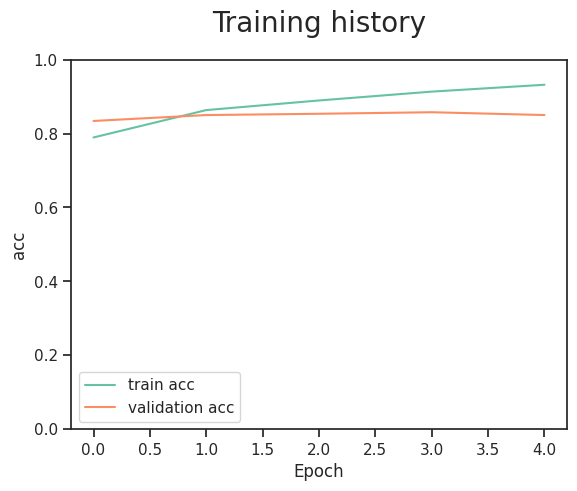

In [ ]:
plt.plot(history['train_acc'], label='train acc')
plt.plot(history['val_acc'], label='validation acc')
plt.title('Training history')
plt.ylabel('acc')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Simpan Hasil Prediksi Validation Set
val_df = pd.read_csv(valid_dataset_path, sep='\t', names=['text', 'category'])
val_df['pred'] = list_hyp
val_df.head()
val_df.to_csv('val result.csv', index=False)

## f. Prediksi Test Set

In [ ]:
# Prediksi test set
model.eval()
torch.set_grad_enabled(False)

total_loss, total_correct, total_labels = 0, 0, 0
pred, list_label = [], []

pbar = tqdm(test_loader, leave=True, total=len(test_loader))
for i, batch_data in enumerate(pbar):
    _, batch_hyp, _ = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    pred += batch_hyp

  0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 6/6 [00:00<00:00,  7.15it/s]


In [ ]:
# Simpan prediksi test set
test_df = pd.read_csv(test_dataset_path, sep='\t', names=['text', 'category'])
test_df['pred'] = pred
test_df.head()
test_df.to_csv('test result.csv', index=False)

## g. Test fine-tuned model on sample sentences

In [ ]:
text = 'Pemerintahan Prabowo dan Gibran dianggap gagal total dalam menepati janji kampanye. Banyak program tidak jelas arahnya dan rakyat merasa kecewa dengan hasil kerja yang jauh dari harapan.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Pemerintahan Prabowo dan Gibran dianggap gagal total dalam menepati janji kampanye. Banyak program tidak jelas arahnya dan rakyat merasa kecewa dengan hasil kerja yang jauh dari harapan. | Label : negative (99.738%)


In [ ]:
text = 'Pemerintahan Prabowo dan Gibran membawa angin segar bagi Indonesia dengan kebijakan inovatif yang fokus pada kemajuan ekonomi, pendidikan, dan kesejahteraan rakyat.'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Pemerintahan Prabowo dan Gibran membawa angin segar bagi Indonesia dengan kebijakan inovatif yang fokus pada kemajuan ekonomi, pendidikan, dan kesejahteraan rakyat. | Label : positive (98.555%)


In [ ]:
text = 'Di bawah kepemimpinan Prabowo dan Gibran, pemerintah menetapkan sejumlah program strategis untuk pembangunan nasional. apakah sesuai dengan visi dan misinya?'
subwords = tokenizer.encode(text)
subwords = torch.LongTensor(subwords).view(1, -1).to(model.device)

logits = model(subwords)[0]
label = torch.topk(logits, k=1, dim=-1)[1].squeeze().item()

print(f'Text: {text} | Label : {i2w[label]} ({F.softmax(logits, dim=-1).squeeze()[label] * 100:.3f}%)')

Text: Di bawah kepemimpinan Prabowo dan Gibran, pemerintah menetapkan sejumlah program strategis untuk pembangunan nasional. apakah sesuai dengan visi dan misinya? | Label : neutral (98.868%)


# 6. Evaluasi

In [ ]:
val_real = val_df.category
val_pred = val_df.pred

test_real = test_df.category
test_pred = test_df.pred

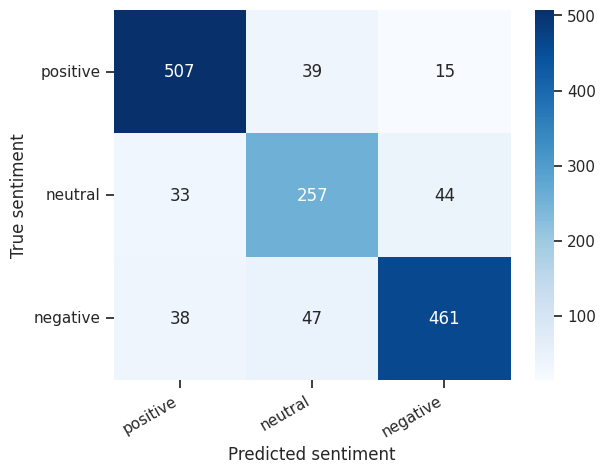

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(val_real, val_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(val_real, val_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.88      0.90      0.89       561
     neutral       0.75      0.77      0.76       334
    negative       0.89      0.84      0.86       546

    accuracy                           0.85      1441
   macro avg       0.84      0.84      0.84      1441
weighted avg       0.85      0.85      0.85      1441



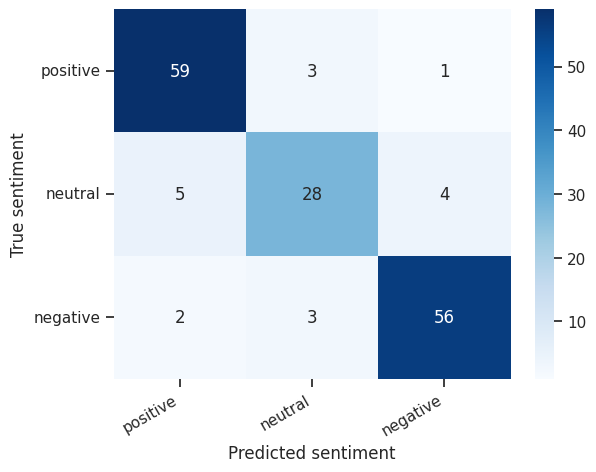

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(test_real, test_pred)
df_cm = pd.DataFrame(cm, index=['positive', 'neutral', 'negative'], columns=['positive', 'neutral', 'negative'])
show_confusion_matrix(df_cm)

In [ ]:
print(classification_report(test_real, test_pred, target_names=['positive', 'neutral', 'negative']))

              precision    recall  f1-score   support

    positive       0.89      0.94      0.91        63
     neutral       0.82      0.76      0.79        37
    negative       0.92      0.92      0.92        61

    accuracy                           0.89       161
   macro avg       0.88      0.87      0.87       161
weighted avg       0.89      0.89      0.89       161



# Tensor Flow

In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
import tensorflow as tf

model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tambahkan classification head (misal untuk 3 kelas)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# (Opsional) Latih model di sini jika kamu punya data

# ✅ Simpan sebagai SavedModel
model.save_pretrained("saved_indobert_tf/")
tokenizer.save_pretrained("saved_indobert_tf/")

In [ ]:
import os
print("Isi folder test_bert:", os.listdir("saved_indobert_tf/"))

In [ ]:
!zip -r saved_indobert_tf.zip saved_indobert_tf
from google.colab import files
files.download("saved_indobert_tf.zip")

# Pytorch

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Misal: setelah fine-tuning IndoBERT
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1")
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Simpan model dan tokenizer
model.save_pretrained("saved_indobert/")
tokenizer.save_pretrained("saved_indobert/")

# torch.save(model.state_dict(), "saved_indobert/pytorch_model.bin")
# model.config.to_json_file("saved_indobert/config.json")
# tokenizer.save_pretrained("saved_indobert/")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('saved_indobert/tokenizer_config.json',
 'saved_indobert/special_tokens_map.json',
 'saved_indobert/vocab.txt',
 'saved_indobert/added_tokens.json',
 'saved_indobert/tokenizer.json')

In [ ]:
torch.save(model.state_dict(), "saved_indobert/pytorch_model.bin")

In [ ]:
import os
print("Isi folder test_bert:", os.listdir("saved_indobert/"))

Isi folder test_bert: ['special_tokens_map.json', 'vocab.txt', 'pytorch_model.bin', 'tokenizer.json', 'model.safetensors', 'tokenizer_config.json', 'config.json']


In [ ]:
import os
print(os.listdir("saved_indobert/"))

['special_tokens_map.json', 'vocab.txt', 'pytorch_model.bin', 'tokenizer.json', 'model.safetensors', 'tokenizer_config.json', 'config.json']


# Sentimen

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Misal: setelah fine-tuning IndoBERT
# Make sure you are saving the *finetuned* model instance, not a newly loaded one
# The 'model' variable here should be the one that was finetuned in the previous steps
# If this cell is run standalone, it loads a *new* model and saves it
# Ensure this cell is run AFTER the finetuning process is complete.
model = AutoModelForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")

# Simpan model dan tokenizer
model.save_pretrained("saved_indobert/") # This should save config.json with the loaded model's config (which might be 5 labels initially)
tokenizer.save_pretrained("saved_indobert/")

# This explicitly saves the state_dict of the model currently in the 'model' variable
torch.save(model.state_dict(), "saved_indobert/pytorch_model.bin")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Assuming the 'model' object here is the one that was finetuned
# (This cell should be run right after the training loop in section e.)

# Simpan model dan tokenizer (after finetuning)
model.save_pretrained("saved_indobert/")
tokenizer.save_pretrained("saved_indobert/")

# Explicitly save the state_dict as well (optional but good practice)
# torch.save(model.state_dict(), "saved_indobert/pytorch_model.bin") # save_pretrained already does this internally

('saved_indobert/tokenizer_config.json',
 'saved_indobert/special_tokens_map.json',
 'saved_indobert/vocab.txt',
 'saved_indobert/added_tokens.json',
 'saved_indobert/tokenizer.json')

In [ ]:
print(model.config.num_labels)  # Harus keluar: 3

3


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

# --- SETUP PATH DAN DEVICE ---
model_path = "saved_indobert"  # Ganti dengan path folder model kamu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- LOAD MODEL & TOKENIZER ---
# This will load config.json (with num_labels=3) and pytorch_model.bin
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

# --- LABEL MAP (PASTIKAN SESUAI TRAINING) ---
# Map the model's output indices (0, 1, 2) to your sentiment labels (0, 1, 2)
# Based on the w2i output earlier: {'neutral': 0, 'positive': 1, 'negative': 2}
# and the order in the confusion matrix (positive, neutral, negative),
# it seems your labels in the DataFrame are 'Positif', 'Netral', 'Negatif'.
# Let's confirm the mapping from the model's output index to your desired label integer.
# Based on your training data and the w2i map {0: 'neutral', 1: 'positive', 2: 'negative'},
# the model outputs 0 for neutral, 1 for positive, and 2 for negative.
# Your label_map seems to map model output index to itself, which is correct if
# your desired output integers are 0 for neutral, 1 for positive, 2 for negative.
# If your DataFrame labels are strings, you'll need to map the predicted index back to string.
# Assuming 0->Netral, 1->Positif, 2->Negatif for the final output:
label_map_to_string = {
    0: 'Neutral',
    1: 'Positive',
    2: 'Negative'
}


# --- FUNGSI PREDIKSI LABEL ---
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    pred_index = torch.argmax(probs, dim=1).item()
    # Map the predicted index to the desired string label
    return label_map_to_string.get(pred_index, 'Unknown') # Return 'Unknown' if index is unexpected


# --- LOAD FILE EXCEL ---
df = pd.read_csv("drive/MyDrive/Data/new_data2.csv")  # Ganti nama file Excel kamu

# --- LAKUKAN PREDIKSI & TAMBAHKAN KOLOM SENTIMEN ---
# Add error handling in case any text causes issues during prediction
def safe_predict_sentiment(text):
    if pd.isna(text): # Handle NaN or None input
        return None
    try:
        return predict_sentiment(str(text)) # Ensure input is string
    except Exception as e:
        print(f"Error predicting sentiment for text: {str(text)[:50]}... Error: {e}")
        return None # Or some other indicator of failure

df["sentimen"] = df["text"].apply(safe_predict_sentiment)

# --- SIMPAN KE FILE BARU ---
df.to_csv("hasil_sentimen_label.csv", index=False)

print("✅ Pelabelan selesai! File disimpan sebagai 'hasil_sentimen_label.csv'.")

✅ Pelabelan selesai! File disimpan sebagai 'hasil_sentimen_label.csv'.
